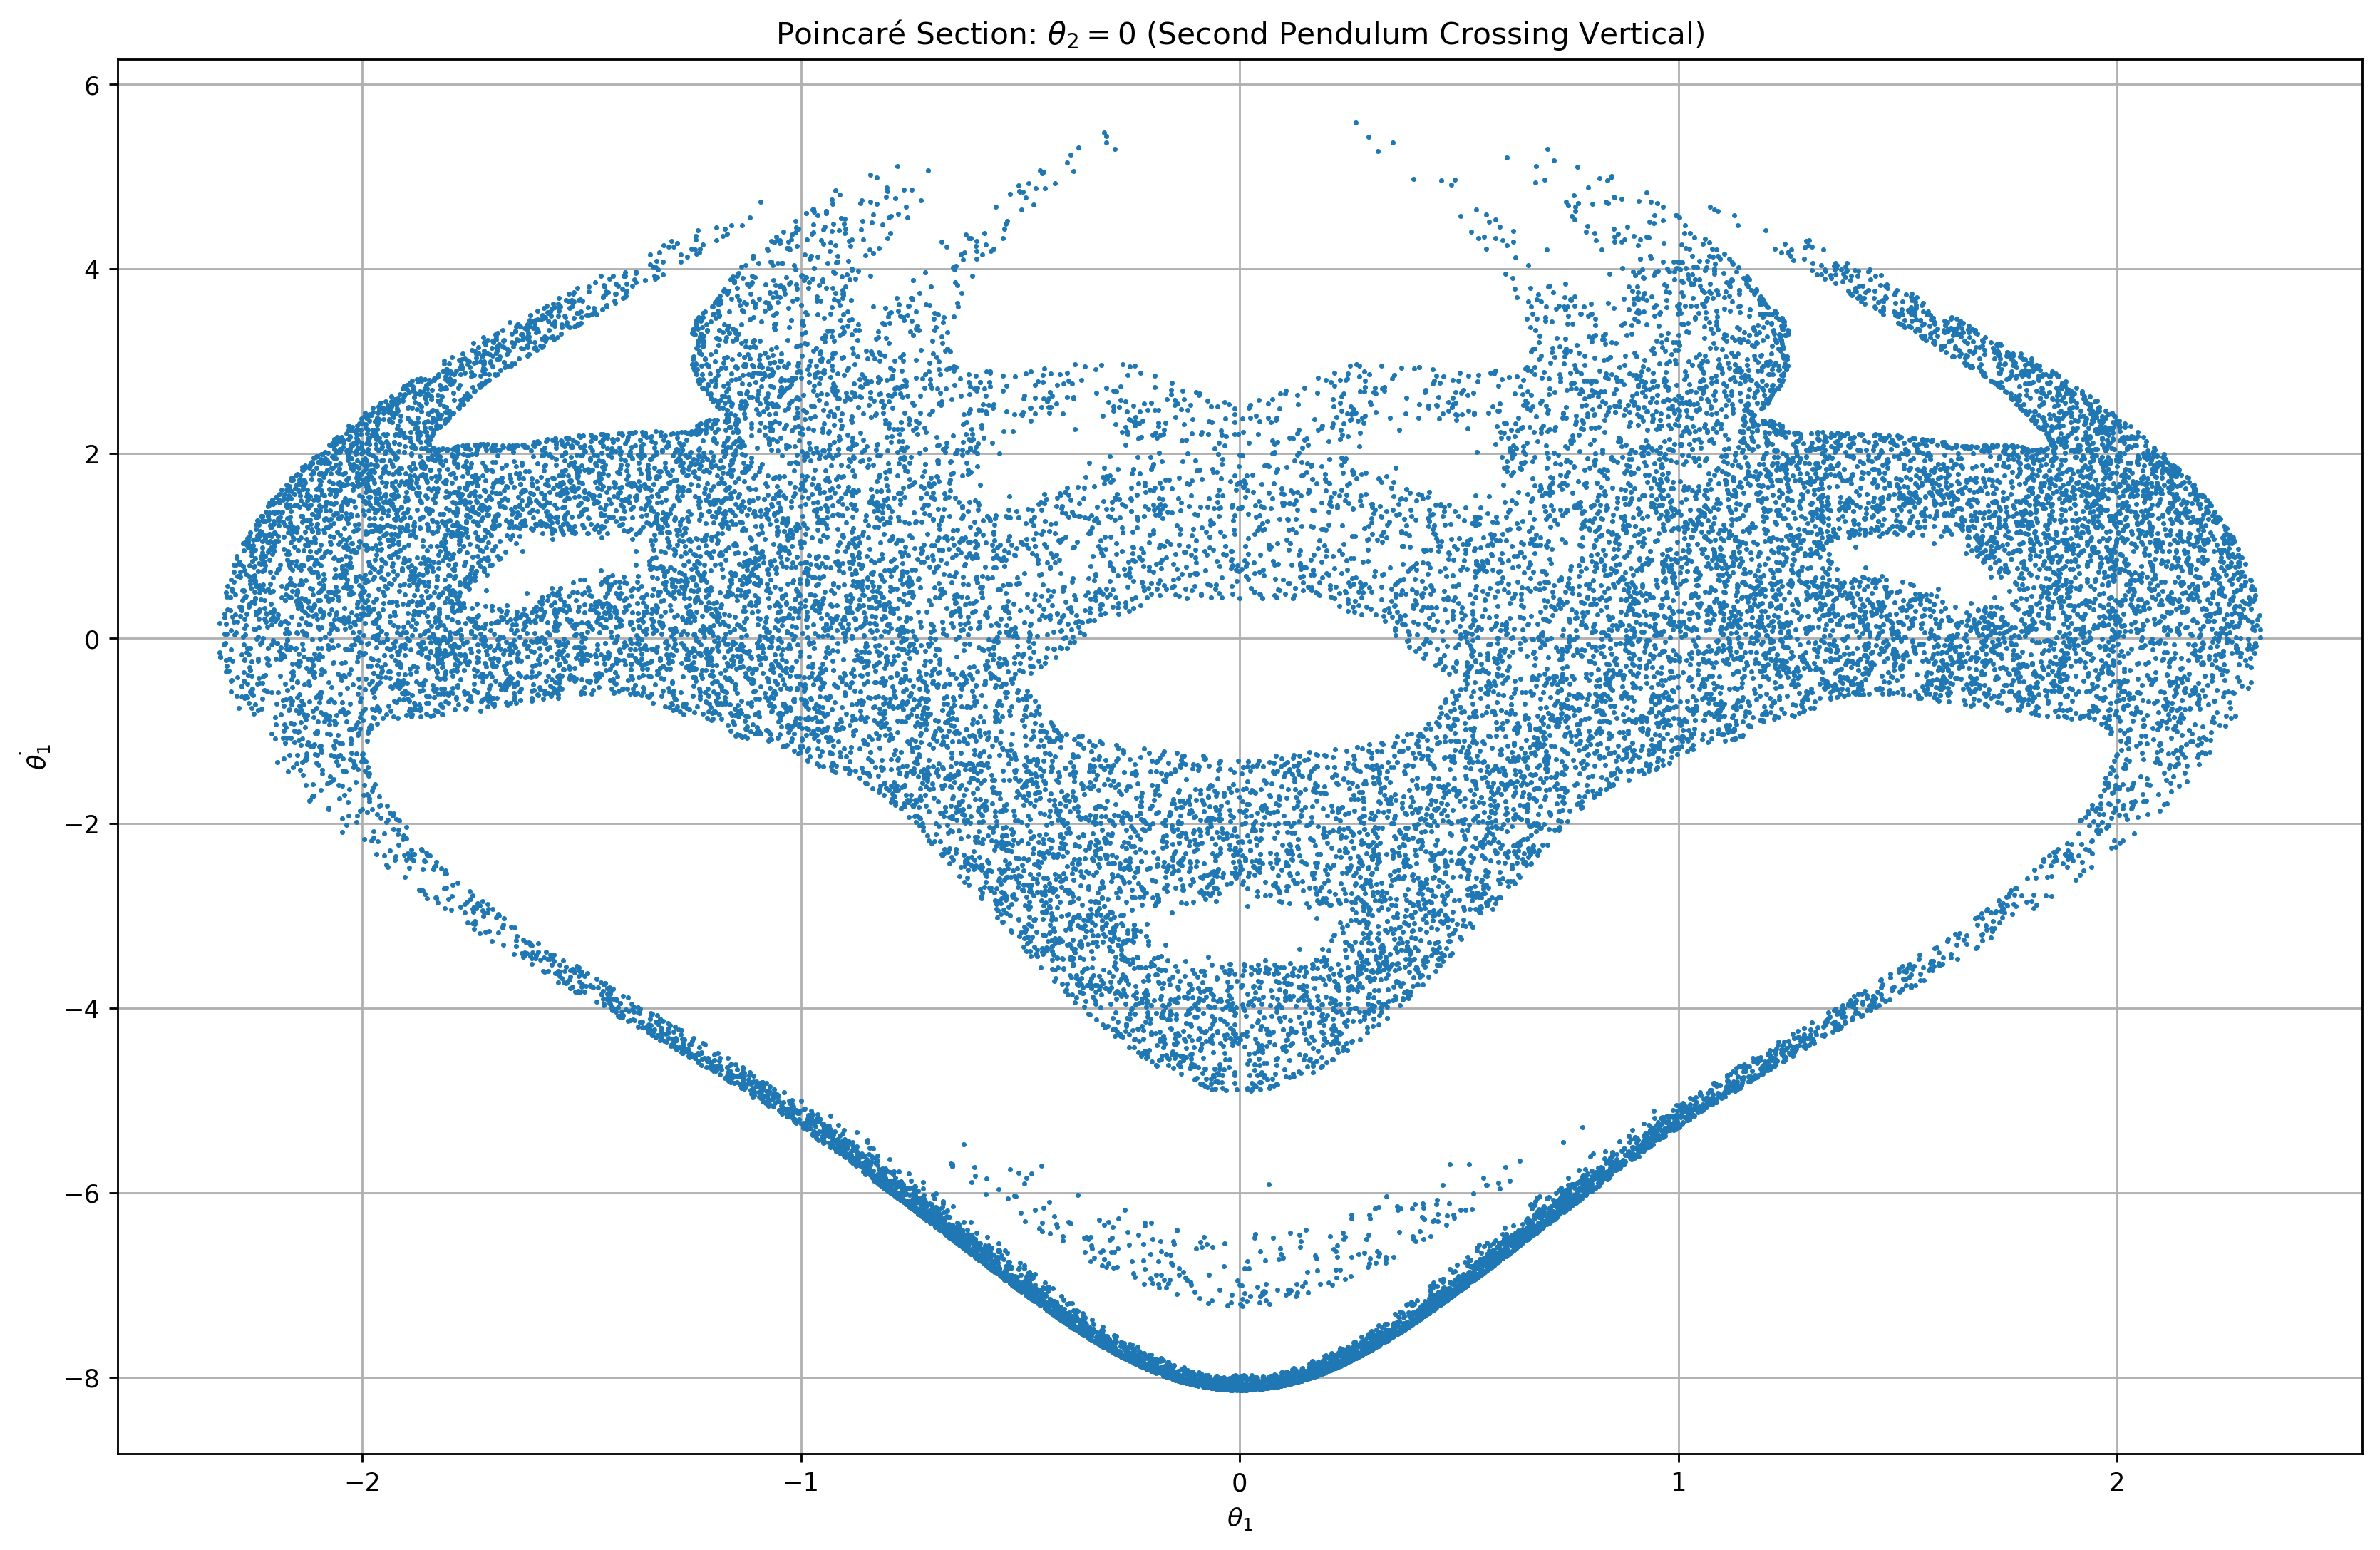

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp  

# Module for calculating the double pendulum motion
class Pendulum:
    """Pendulum class for storing pendulum properties"""
    def __init__(self, L, m):
        self.L = L  # Length of the pendulum
        self.m = m  # Mass of the pendulum

def derivative(t, y, L1, L2, m1, m2, g):
    """Return the first derivatives of y = [theta1, z1, theta2, z2]."""
    theta1, z1, theta2, z2 = y
    c, s = np.cos(theta1 - theta2), np.sin(theta1 - theta2)

    z1dot = _calculate_z1dot(m1, m2, L1, L2, theta1, theta2, z1, z2, g, s, c)
    z2dot = _calculate_z2dot(m1, m2, L1, L2, theta1, theta2, z1, z2, g, s, c)
    
    return [z1, z1dot, z2, z2dot]

def _calculate_z1dot(m1, m2, L1, L2, theta1, theta2, z1, z2, g, s, c) -> float:
    """Calculate the second derivative of theta1 (z1dot)."""
    return (m2 * g * np.sin(theta2) * c - m2 * s * (L1 * z1**2 * c + L2 * z2**2) - (m1 + m2) * g * np.sin(theta1)) / L1 / (m1 + m2 * s**2)

def _calculate_z2dot(m1, m2, L1, L2, theta1, theta2, z1, z2, g, s, c) -> float:
    """Calculate the second derivative of theta2 (z2dot)."""
    return ((m1 + m2) * (L1 * z1**2 * s - g * np.sin(theta2) + g * np.sin(theta1) * c) + m2 * L2 * z2**2 * s * c) / L2 / (m1 + m2 * s**2)

# Initial conditions and parameters
L1, L2 = 1.0, 1.0  # Length of pendulums
m1, m2 = 1.0, 1.0  # Masses of the pendulums
g = 9.81  # Gravitational acceleration
t_span = (0, 50000)  # Time range (start, end)
t_eval = np.linspace(0, 50000, 100000000)  # Time array for evaluation (time step needs to be fine enough)

# Initial state [theta1, z1, theta2, z2]
y0 = [np.pi /2.4, 0.0, np.pi/4.8, 0.0]

# Create pendulum objects
pendulum1 = Pendulum(L1, m1)
pendulum2 = Pendulum(L2, m2)

# Solve the ODEs using solve_ivp
sol = solve_ivp(
    derivative,
    t_span,
    y0,
    args=(L1, L2, m1, m2, g),
    t_eval=t_eval,
    method='LSODA',  # 'LSODA' is adaptive and handles stiff equations
    rtol=1e-8,  # Relative tolerance 
    atol=1e-8   # Absolute tolerance 
)

# Extract the solution
theta1 = sol.y[0]
z1 = sol.y[1]
theta2 = sol.y[2]
z2 = sol.y[3]

# Create the Poincaré section (for theta2 = 0); can adjust to other definitions of poincare sections
poincare_section = []

for i in range(1, len(sol.t) - 1):
    # Detect when theta2 crosses zero (from negative to positive)
    if theta1[i-1] < 0 and theta1[i] > 0:
        # Append [theta1, z1] to the Poincaré section
        poincare_section.append([theta2[i], z2[i]])

# Convert Poincaré section to a numpy array for easy plotting
poincare_section = np.array(poincare_section)

# Plot the Poincaré section (theta1 vs z1)
plt.figure(figsize=(16, 10), dpi=254)
plt.plot(poincare_section[:, 0], poincare_section[:, 1], 'o', markersize=1)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\dot{\theta_1}$')
plt.title(r'Poincaré Section: $\theta_2 = 0$ (Second Pendulum Crossing Vertical)')
plt.grid(True)
plt.show()


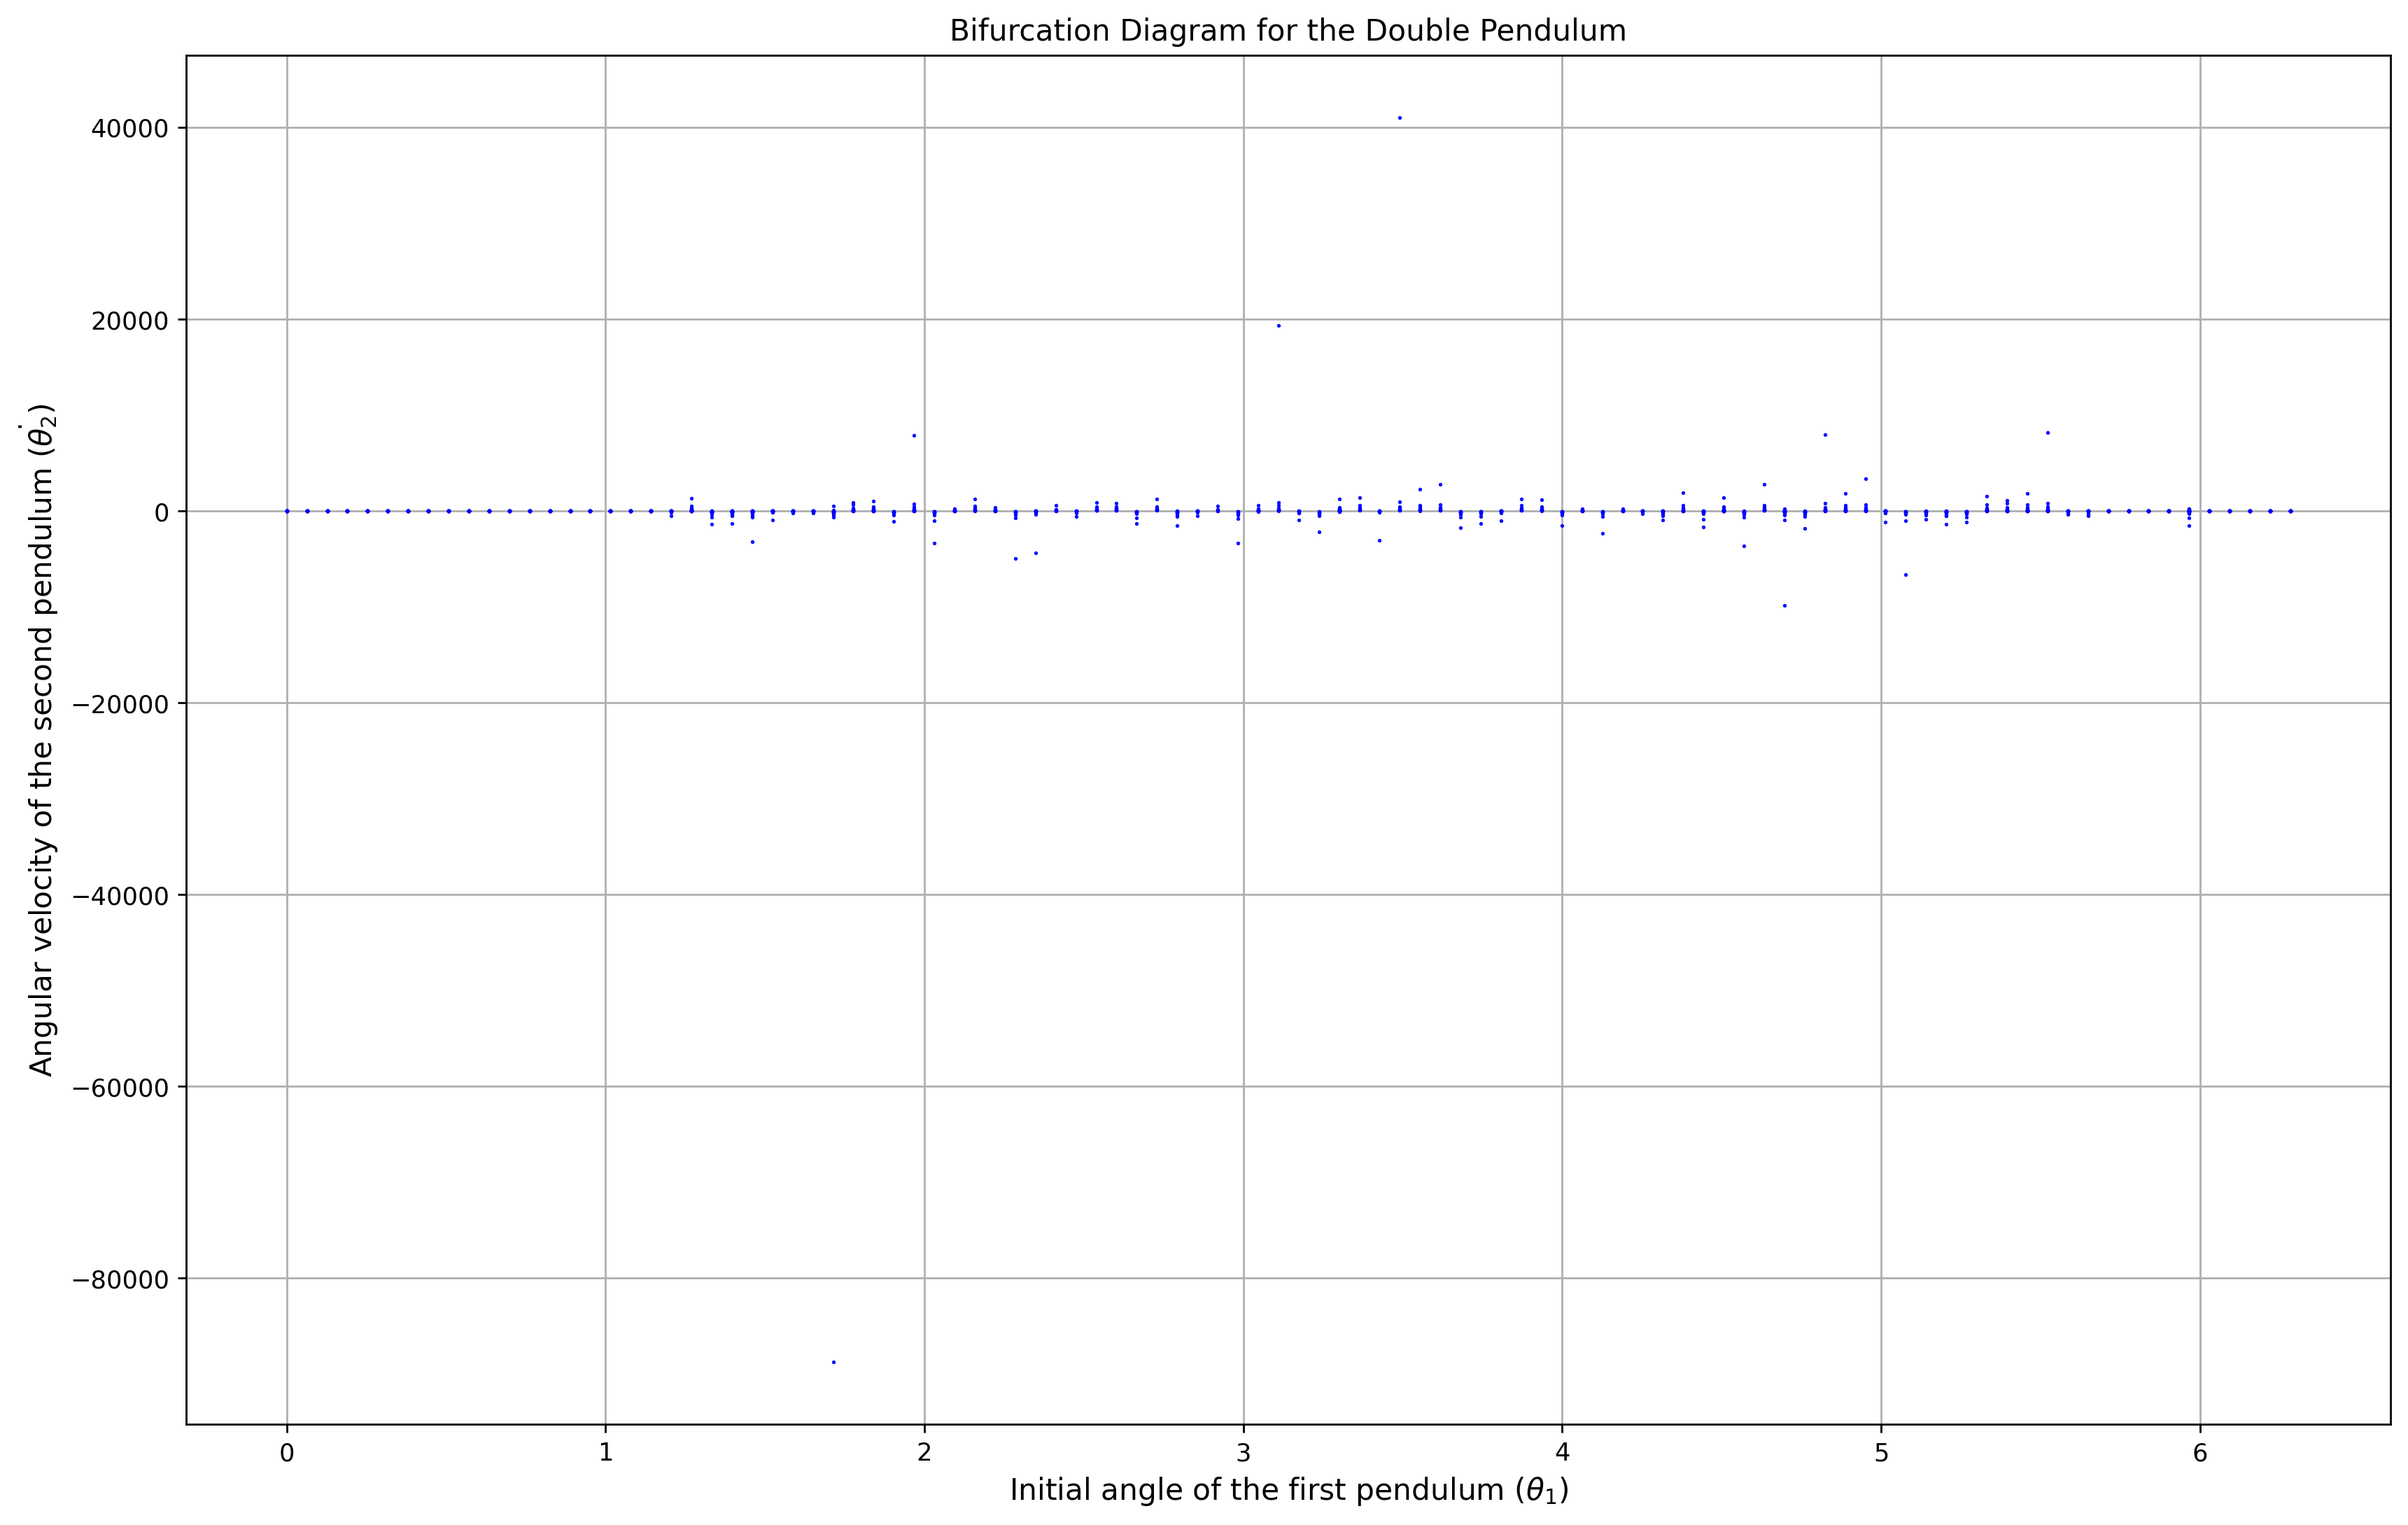

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Function to simulate the system for a range of initial angles (theta1_0)
def bifurcation_diagram():
    # Initial conditions
    theta1_0 = np.pi / 2.4  # initial angle of the second pendulum (radians)
    theta2_0 = np.pi / 4.8  # initial angle of the second pendulum (radians)
    z1_0 = 0.0            # initial angular velocity for the first pendulum (rad/s)
    z2_0 = 0.0            # initial angular velocity for the second pendulum (rad/s)

    # Reduced range of initial theta1_0 values
    theta1_values = np.linspace(0.0, 2 * np.pi, 100)  # Initial conditions for theta1_0
    final_z2_values = []  # To store the final angular velocities of the second pendulum (z2)
    theta1_for_plotting = []  # To store theta1 values for plotting

    # Time span for the simulation (more computationally demanding than creating poincare sections)
    t_span = (0, 500)  # Simulate for 500 seconds
    t_eval = np.linspace(0, 500, 500)  # Time evaluation points (2500 points)

    # Iterate over each initial condition of theta1_0
    for theta1_0 in theta1_values:
        y0 = [theta1_0, z1_0, theta2_0, z2_0]  # Initial state for the system

        # Solve the ODEs
        solution = solve_ivp(derivative, t_span, y0, t_eval=t_eval, args=(L1, L2, m1, m2, g), method='RK45')

        # Extract the angular velocity of the second pendulum (z2)
        z2 = solution.y[3]

        # Discard the first 90% of the time to remove transients (settling into equilibrium)
        z2_transient_removed = z2[int(0.9 * len(z2)):]

        # Append the angular velocities of the second pendulum and the corresponding theta1_0 values
        final_z2_values.extend(z2_transient_removed)
        theta1_for_plotting.extend([theta1_0] * len(z2_transient_removed))

    # Plot the bifurcation diagram
    plt.figure(figsize=(16, 10), dpi=254)
    plt.plot(theta1_for_plotting, final_z2_values, '.', markersize=1, color='b')
    plt.title("Bifurcation Diagram for the Double Pendulum")
    plt.xlabel(r"Initial angle of the first pendulum ($\theta_1$)", fontsize=12)
    plt.ylabel(r"Angular velocity of the second pendulum ($\dot{\theta_2}$)", fontsize=12)
    plt.grid(True)
    plt.show()

# Run the bifurcation diagram function
bifurcation_diagram()
